# **Deep learning for dynamic network analysis (DLDNA)** <br> Final project

**Dolphins:** R. ARNAUD M. DELPLANQUE A. KARILA-COHEN A. RAMPOLDI

Comprehensive soil classification dataset: https://www.kaggle.com/datasets/ai4a-lab/comprehensive-soil-classification-datasets/code

### **1. Preliminnary tasks**

**Import of the libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings to keep notebook clean

import random
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import sys
import pandas as pd
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt

**Path configuration**

In [10]:
PROJECT_ROOT = Path.cwd().parent.resolve()
DATA_DIR= PROJECT_ROOT / "data"
PARAM_FILE = PROJECT_ROOT / "txt" / "parameters.txt"
# utils.py functions
UTILS_DIR = PROJECT_ROOT / "src"
sys.path.append(str(PROJECT_ROOT / "src"))
from utils import load_parameters, load_images

**Choose the good torch device**

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'xpu' if hasattr(torch, "xpu") and torch.xpu.is_available() else 'cpu'
print(f"Params loaded. Device: {DEVICE}")

Params loaded. Device: cpu


**General parameters**

In [5]:
# Load parameters from external file
params = load_parameters(PARAM_FILE)
globals().update(params)


Loaded parameters:
  TRAIN_RATIO = 0.7
  VAL_RATIO = 0.1
  TEST_RATIO = 0.2
  BATCH_SIZE = 32
  EPOCHS = 100
  LEARNING_RATE = 0.01
  SEED = 42


**Seeding to ensure reproducibility**

In [11]:
# Use parameters for seed and device
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

**Load the dataset**

In [12]:
soil_types = [
    "Alluvial_Soil",
    "Arid_Soil",
    "Black_Soil",
    "Laterite_Soil",
    "Mountain_Soil",
    "Red_Soil",
    "Yellow_Soil",
]

images_dict = {}

for soil in soil_types:
    folder = DATA_DIR / "Orignal-Dataset" / soil
    images_dict[soil] = load_images(folder)
    print(f"{soil}: {len(images_dict[soil])} images loaded")


Alluvial_Soil: 51 images loaded
Arid_Soil: 284 images loaded
Black_Soil: 255 images loaded
Laterite_Soil: 219 images loaded
Mountain_Soil: 201 images loaded
Red_Soil: 109 images loaded
Yellow_Soil: 69 images loaded


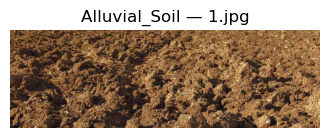

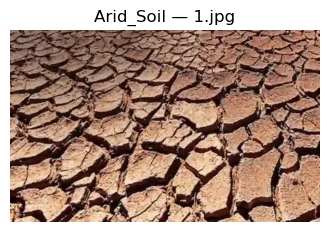

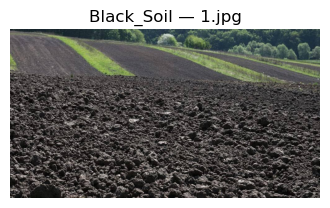

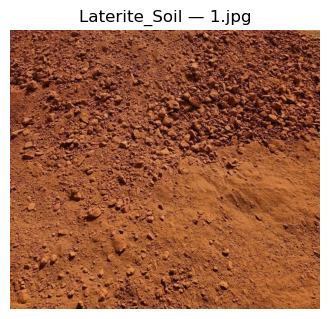

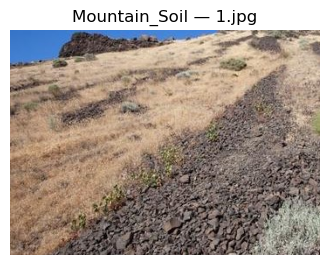

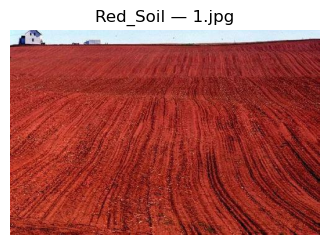

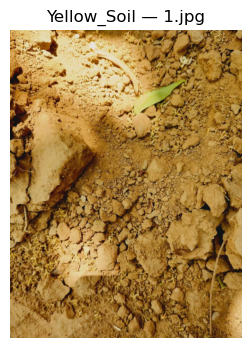

In [13]:
for label, images in images_dict.items():
    if len(images) == 0:
        print(f"{label}: no images")
        continue

    img, name = images[0]

    # OpenCV (BGR) -> matplotlib (RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.title(f"{label} — {name}")
    plt.axis("off")
    plt.show()